## Library

In [65]:
import pandas as pd
import numpy as np
import re
import jax
from IPython.display import Markdown, display
import jax.numpy as jnp
from numpyro.infer import MCMC, NUTS
from tqdm import tqdm
import arviz as az
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
import numpyro
from jax import random
import numpyro.distributions as dist
import matplotlib.dates as mdates
from datetime import datetime
from numpyro.contrib.control_flow import scan
import matplotlib as mpl
import warnings
warnings.simplefilter('ignore')
import seaborn as sns

numpyro.enable_x64()    

class ProgressBar:
    def __init__(self, total):
        self.pbar = tqdm(total=total, desc="Sampling Progress", position=0, leave=True)

    def update(self, value):
        self.pbar.update(value)

    def close(self):
        self.pbar.close()

def get_model_number(model_str):
    nums = re.findall(r'\d+', model_str)
    if nums:
        return int(nums[-1])
    else:
        return None
colors = ['black', 'blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray']

# --------------------------------------------------------
# global style
# --------------------------------------------------------
mpl.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 12,
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "lines.linewidth": 1.5,
    "axes.grid": True,
    "grid.alpha": 0.3,
})

# --------------------------------------------------------
# helper: draw one decomposition in an existing Axes
# --------------------------------------------------------
def plot_decomposition_ax(ax, date, original, trend, cycle, title, loc="upper left"):
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

    # level & trend  ------------------------
    ax.plot(date, original, label="Original", color=colors[0])
    ax.plot(date, trend,    label="Trend",    color=colors[1])
    ax.set_xlabel("Year")
    ax.set_ylabel("level / trend")
    ax.set_title(title)
    ax.grid(True, linestyle="--", alpha=0.4)

    # cycle (twin axis) ---------------------
    ax2 = ax.twinx()
    ax2.plot(date, cycle, label="Cycle", color=colors[2])
    ax2.axhline(0, color="gray", linestyle="--", linewidth=1)
    ax2.set_ylabel("Cycle")
    ax2.tick_params(axis="y", colors=colors[2])

    # legend (combine both axes) ------------
    lines  = ax.get_lines() + ax2.get_lines()
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc=loc, frameon=False)


In [66]:
# cpi data
data_cpi = pd.read_csv("data/CPIAUCSL.csv", parse_dates=["DATE"])
data_cpi.set_index("DATE", inplace=True)
data_cpi = data_cpi.resample("QS").mean()
data_cpi['pi'] = data_cpi['CPIAUCSL'].pct_change() * 100
data_cpi = data_cpi['pi']
data_cpi = data_cpi.reset_index()
data_cpi['DATE'] = pd.to_datetime(data_cpi['DATE'])

# Markup data
data_markup = pd.read_excel("data/nekarda_ramey_markups.xlsx")
data_markup['DATE'] = pd.to_datetime(data_markup['qdate'], format='%Y-%m-%d')
data_markup['markup'] = data_markup['mu_bus']
data_markup = data_markup[['DATE', 'markup']].dropna()

# output gap data
data_output = pd.read_csv("data/BN_filter_GDPC1_quaterly.csv")
data_output['output_BN'] = data_output['GDPC1_transformed_series']
data_output['output_gap_BN'] = data_output["cycle"]
data_output['output'] = np.log(data_output["GDPC1_original_series"] * 0.01)
data_output['DATE'] = data_output["date"]
data_output["output_trend_BN"] = data_output["output_BN"] - data_output["output_gap_BN"]
data_output = data_output[["DATE", "output_BN", "output_gap_BN", "output_trend_BN", "output"]].dropna()
data_output['DATE'] = pd.to_datetime(data_output['DATE'])


# inflation expectation data
data_Epi = pd.read_csv("data/one_year_inflation_expectation.csv")
data_Epi['DATE'] = pd.to_datetime(data_Epi['Model Output Date'])
data_Epi.set_index("DATE", inplace=True)
data_Epi = data_Epi[[" 1 year Expected Inflation"]].resample("QS").mean() * 100 / 4
data_Epi['Epi'] = data_Epi[' 1 year Expected Inflation']
data_Epi = data_Epi.reset_index()
data_Epi = data_Epi[["DATE", "Epi"]]
data_Epi['DATE'] = pd.to_datetime(data_Epi['DATE'])

# HHI
data_N_annual = pd.read_excel("data/WITS-Country-Timeseries.xlsx")
data_N_annual["HHI"] = data_N_annual["Unnamed: 1"]
data_N_annual['year'] = pd.to_datetime(data_N_annual['year'], format='%Y') + pd.offsets.YearBegin(0)
data_N_annual = data_N_annual.set_index('year')
data_N = data_N_annual.resample('QS').asfreq()
data_N['HHI'] = data_N['HHI'].interpolate(method='linear')
data_N = data_N.reset_index()
data_N['DATE'] = pd.to_datetime(data_N['year'])
data_N = data_N[["DATE", "HHI"]]
data_N["N"] = np.log(1/data_N["HHI"]) 
data_N.to_csv("data/N_HHI.csv", index=False)


data_N_hat_annual = pd.read_csv("data/BN_filter_user_inputted_series_results_HHI.csv")
data_N_hat_annual["year"] = (
    pd.to_datetime(data_N_hat_annual["date"])   # ①
      .dt.year                                  # ②
)
data_N_hat_annual['DATE'] = pd.to_datetime(data_N_hat_annual['year'], format='%Y') + pd.offsets.YearBegin(0)
data_N_hat_annual = data_N_hat_annual.set_index('DATE')
data_N_hat = data_N_hat_annual.resample('QS').asfreq()
data_N_hat = data_N_hat.reset_index()
data_N_hat['N_hat_BN'] = data_N_hat['cycle'].interpolate(method='linear')
data_N_hat["original_series"] = data_N_hat['original_series'].interpolate(method='linear')
data_N_hat["N_trend_BN"] = data_N_hat['trend'].interpolate(method='linear')
data_N_hat = data_N_hat[["DATE", "N_hat_BN", "N_trend_BN"]]

# Merge all dataframes
data = pd.merge(data_cpi, data_Epi, on="DATE", how="outer")
data = pd.merge(data, data_output, on="DATE", how="outer")
data = pd.merge(data, data_N, on="DATE", how="outer")
data = pd.merge(data, data_markup, on="DATE", how="outer")
data = pd.merge(data, data_N_hat, on="DATE", how="outer")
data["pi_prev"] = data["pi"].shift(1)
data["output_gap_prev"] = data["output_gap_BN"].shift(1)
data["markup_prev"] = data["markup"].shift(1)
data = data.dropna()

In [67]:
data_1 = data[data["DATE"] <= "2008-01-01"]
data_2 = data[data["DATE"] > "2009-01-01"]

# for MCMC
pi_1 = jnp.array(data_1['pi'],dtype=jnp.float64)
pi_2 = jnp.array(data_2['pi'],dtype=jnp.float64)
pi_prev_1 = jnp.array(data_1['pi_prev'],dtype=jnp.float64)
pi_prev_2 = jnp.array(data_2['pi_prev'],dtype=jnp.float64)
pi_expect_1 = jnp.array(data_1['Epi'],dtype=jnp.float64)
pi_expect_2 = jnp.array(data_2['Epi'],dtype=jnp.float64)
N_1 = jnp.array(data_1['N'],dtype=jnp.float64)
N_2 = jnp.array(data_2['N'],dtype=jnp.float64)
# Nb = jnp.array(data['Nb'],dtype=jnp.float64)
Y_1 = jnp.array(data_1['output'],dtype=jnp.float64)
Y_2 = jnp.array(data_2['output'],dtype=jnp.float64)
x_markup_1 = jnp.array(1/data_1['markup'],dtype=jnp.float64)
x_markup_2 = jnp.array(1/data_2['markup'],dtype=jnp.float64)
x_markup_prev_1 = jnp.array(1/data_1['markup_prev'],dtype=jnp.float64)
x_markup_prev_2 = jnp.array(1/data_2['markup_prev'],dtype=jnp.float64)
x_outputgap_1 = jnp.array(data_1['output_gap_BN'],dtype=jnp.float64)
x_outputgap_2 = jnp.array(data_2['output_gap_BN'],dtype=jnp.float64)
x_outputgap_prev_1 = jnp.array(data_1['output_gap_prev'],dtype=jnp.float64)
x_outputgap_prev_2 = jnp.array(data_2['output_gap_prev'],dtype=jnp.float64)

In [68]:
warmup=1000
samples=4000
chains = 2
rng_key = jax.random.PRNGKey(0)
rng_keys = jax.random.split(rng_key, chains)

def set_prior_distributions():
    priors = {
        # NKPC params
        "alpha"      : dist.Beta(2, 5),
        "kappa"      : dist.Beta(2, 5),
        "kappa_init" : dist.Beta(2, 5),
        "theta"      : dist.Beta(2, 5),
        "delta"      : dist.Beta(2, 5),
        "psi"        : dist.Beta(2, 5),
        "n"          : dist.Normal(0, 1),
        # Sigma
        "sigma_u"    : dist.LogNormal(0, 1),  
        "sigma_eps"  : dist.LogNormal(0, 1),  
        "sigma_v"    : dist.LogNormal(0, 1),  
        "sigma_mu"   : dist.LogNormal(0, 1),  
        "sigma_e"    : dist.LogNormal(0, 1),  
        "sigma_eta"  : dist.LogNormal(0, 1),  
    }
    return priors

In [69]:
def model_0(pi, pi_prev, pi_expect, x):
    priors = set_prior_distributions()
    # NKPC params
    alpha = numpyro.sample("alpha", priors["alpha"])
    kappa = numpyro.sample("kappa", priors["kappa"])
    # Sigma
    sigma_v = numpyro.sample("sigma_v", priors["sigma_v"])
    # model
    pi_pred = alpha * pi_prev + (1-alpha) * pi_expect + kappa * x
    numpyro.sample(f"pi_obs", numpyro.distributions.Normal(pi_pred, sigma_v), obs=pi)

def model_1(pi, pi_prev, pi_expect, x, N, l):
    priors = set_prior_distributions()
    # NKPC params
    alpha = numpyro.sample("alpha",priors["alpha"])
    kappa = numpyro.sample("kappa", priors["kappa"])
    theta = numpyro.sample("theta", priors["theta"])
    # State equation (N) params
    rho_1 = numpyro.sample("rho_1", dist.Uniform(0,2))
    rho_2 = numpyro.sample("rho_2", dist.Uniform(-1,0))
    # r = numpyro.sample("r", dist.Uniform(-1,1))  # root for AR2
    # p = numpyro.sample("p", dist.Uniform(0.1, 0.9))  # phi for AR2
    # rho_1 = 2 * r * jnp.cos(jnp.pi * p)
    # rho_2 = -r ** 2
    # numpyro.deterministic("rho_1", rho_1) # Nhat AR1 coeff
    # numpyro.deterministic("rho_2", rho_2) # Nhat AR2 coeff
    n = numpyro.sample("n", priors["n"])
    # Sigma
    sigma_v  = numpyro.sample("sigma_v", priors["sigma_v"])      
    sigma_u  = numpyro.sample("sigma_u", priors["sigma_u"])      
    sigma_eps = numpyro.sample("sigma_eps", priors["sigma_eps"]) 
    # initial 
    bar_N_0  = numpyro.sample("bar_N_0", dist.Normal(N[0], 1))   # Nbar init
    hat_N_0  = numpyro.sample("hat_N_0", dist.Normal(0, .05))    # Nhat init
    hat_N_1  = numpyro.sample("hat_N_1", dist.Normal(0, .05))    # Nhat init
    # state space model
    timesteps = jnp.arange(l)
    t = 0
    def transition(carry, _):
        Nbar_prev = carry[0]
        Nhat_prev_1 = carry[1]
        Nhat_prev_2 = carry[2]
        t = carry[3]
        # state equation
        # trend 
        Nbar_t  = numpyro.sample("Nbar", dist.Normal(n + Nbar_prev, sigma_eps))
        # N (Nbar + Nhat = observed N)
        N_hat_obs = N[t] - Nbar_t
        # cycle
        N_hat_pred = rho_1 * Nhat_prev_1 + rho_2 * Nhat_prev_2
        Nhat_t = numpyro.sample("Nhat_t", dist.Normal(N_hat_pred, sigma_u), obs=N_hat_obs)
        numpyro.deterministic("Nhat", Nhat_t) 
        # pi
        pi_pred = alpha * pi_prev[t] + (1-alpha) * pi_expect[t] + kappa * x[t] - theta * Nhat_t
        numpyro.sample(f"pi_obs", dist.Normal(pi_pred, sigma_v), obs=pi[t])
        t = t + 1
        return [Nbar_t, Nhat_t, Nhat_prev_1 , t], None
    scan(transition, [bar_N_0, hat_N_0, hat_N_1, t], timesteps)


In [70]:
# NKPC under CES
# NKPC under CES before financial crisis ======================================
print("NKPC under CES before financial crisis")
kernel = NUTS(model_0, target_accept_prob=0.995)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc.run(rng_keys, pi=pi_1, pi_prev=pi_prev_1, pi_expect=pi_expect_1, x=x_markup_1)
idata_0_m_1 = az.from_numpyro(mcmc)
posterior_samples = mcmc.get_samples()
diverging  = idata_0_m_1.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()                               # mean of 0/1 booleans = share of divergences
print(f"model 0.1: divergence ratio = {ratio_div:.4%}")     # bool for each param
# =============================================================================

# NKPC under CES after financial crisis =======================================
print("NKPC under CES before financial crisis")
kernel = NUTS(model_0, target_accept_prob=0.995)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc.run(rng_keys, pi=pi_2, pi_prev=pi_prev_2, pi_expect=pi_expect_2, x=x_markup_2)
idata_0_m_2 = az.from_numpyro(mcmc)
posterior_samples = mcmc.get_samples()
diverging  = idata_0_m_2.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()                               # mean of 0/1 booleans = share of divergences
print(f"model 0.2: divergence ratio = {ratio_div:.4%}")     # bool for each param
# =============================================================================
# Summary statistics
dict_idata = {'NKPC under CES before financial crisis':idata_0_m_1, 'NKPC under CES after financial crisis':idata_0_m_2}
params = ["alpha", "kappa", "sigma_v", "theta", "rho_1", "rho_2", "n"]
df_list = []
for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    for param in params:
        if param in available_params:
            summary = az.summary(idata, var_names=[param], kind="stats")
            if param in summary.index:
                row[param] = f"{summary.loc[param, 'mean']:.3f}"
            else:
                row[param] = "-"
        else:
            row[param] = "-"
    df_list.append(row)

summary_df = pd.DataFrame(df_list)
display(summary_df)

NKPC under CES before financial crisis


sample: 100%|██████████| 5000/5000 [00:02<00:00, 2253.87it/s, 15 steps of size 1.94e-01. acc. prob=0.99]


model 0.1: divergence ratio = 0.0000%
NKPC under CES before financial crisis


sample: 100%|██████████| 5000/5000 [00:01<00:00, 3169.79it/s, 15 steps of size 2.03e-01. acc. prob=0.99]


model 0.2: divergence ratio = 0.0000%


,model,alpha,kappa,sigma_v,theta,rho_1,rho_2,n
0,NKPC under CES before financial crisis,0.148,0.061,0.325,-,-,-,-
1,NKPC under CES after financial crisis,0.183,0.136,0.346,-,-,-,-


In [71]:
# NKPC under HSA
# NKPC under HSA: no shift in slope before financial crisis ===================
print("NKPC under HSA: no shift in slope")
# model 1
kernel = NUTS(model_1, target_accept_prob=0.95)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc.run(rng_keys, pi=pi_1, pi_prev=pi_prev_1, pi_expect=pi_expect_1, x=x_markup_1, N = N_1, l=len(pi_1))
idata_1_m_1 = az.from_numpyro(mcmc)
posterior_samples = mcmc.get_samples()
N_bar_samples_1 = posterior_samples["Nbar"]
N_bar_mean_1_m_1 = np.mean(N_bar_samples_1, axis=0) 
N_bar_std_1_m_1 = np.std(N_bar_samples_1, axis=0)  
N_bar_lower_1_m_1 = N_bar_mean_1_m_1 - 1.97 * N_bar_std_1_m_1
N_bar_upper_1_m_1 = N_bar_mean_1_m_1 + 1.97 * N_bar_std_1_m_1
N_hat_samples_1 = posterior_samples["Nhat"]
N_hat_mean_1_m_1 = np.mean(N_hat_samples_1, axis=0) 
N_hat_std_1_m_1 = np.std(N_hat_samples_1, axis=0)  
N_hat_lower_1_m_1 = N_hat_mean_1_m_1 - 1.97 * N_hat_std_1_m_1
N_hat_upper_1_m_1 = N_hat_mean_1_m_1 + 1.97 * N_hat_std_1_m_1
diverging  = idata_1_m_1.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"Model 1.1 : divergence ratio = {ratio_div:.4%}")
# =============================================================================

# NKPC under HSA: no shift in slope after financial crisis ==================
kernel = NUTS(model_1, target_accept_prob=0.95)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel", progress_bar=True)
mcmc.run(rng_keys, pi=pi_2, pi_prev=pi_prev_2, pi_expect=pi_expect_2, x=x_markup_2, N = N_2, l=len(pi_2))
idata_1_m_2 = az.from_numpyro(mcmc)
posterior_samples = mcmc.get_samples()
N_bar_samples_2 = posterior_samples["Nbar"]
N_bar_mean_1_m_2 = np.mean(N_bar_samples_2, axis=0)
N_bar_std_1_m_2 = np.std(N_bar_samples_2, axis=0)
N_bar_lower_1_m_2 = N_bar_mean_1_m_2 - 1.97 * N_bar_std_1_m_2
N_bar_upper_1_m_2 = N_bar_mean_1_m_2 + 1.97 * N_bar_std_1_m_2
N_hat_samples_2 = posterior_samples["Nhat"]
N_hat_mean_1_m_2 = np.mean(N_hat_samples_2, axis=0)
N_hat_std_1_m_2 = np.std(N_hat_samples_2, axis=0)
N_hat_lower_1_m_2 = N_hat_mean_1_m_2 - 1.97 * N_hat_std_1_m_2
N_hat_upper_1_m_2 = N_hat_mean_1_m_2 + 1.97 * N_hat_std_1_m_2
diverging  = idata_1_m_2.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"Model 1.2 : divergence ratio = {ratio_div:.4%}")
# =============================================================================
# Summary statistics
dict_idata = {'NKPC under HSA before financial crisis': idata_1_m_1, 'NKPC under HSA after financial crisis': idata_1_m_2}
params = ["alpha", "kappa", "sigma_v", "theta", "rho_1", "rho_2", "n"]
df_list = []
for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    for param in params:
        if param in available_params:
            summary = az.summary(idata, var_names=[param], kind="stats")
            if param in summary.index:
                row[param] = f"{summary.loc[param, 'mean']:.3f}"
            else:
                row[param] = "-"
        else:
            row[param] = "-"
    df_list.append(row)

summary_df = pd.DataFrame(df_list)
display(summary_df)

NKPC under HSA: no shift in slope


sample: 100%|██████████| 5000/5000 [06:28<00:00, 12.88it/s, 1023 steps of size 4.39e-03. acc. prob=0.94]


Model 1.1 : divergence ratio = 0.0000%


sample: 100%|██████████| 5000/5000 [01:57<00:00, 42.44it/s, 1023 steps of size 3.64e-03. acc. prob=0.93]


Model 1.2 : divergence ratio = 0.0000%


,model,alpha,kappa,sigma_v,theta,rho_1,rho_2,n
0,NKPC under HSA before financial crisis,0.117,0.090,0.308,0.407,1.914,-0.921,0.014
1,NKPC under HSA after financial crisis,0.182,0.144,0.346,0.268,1.751,-0.760,-0.006


In [72]:
# NKPC under HSA:
#  shift in slope before financial crisis ==================
def model_2(pi, pi_prev, pi_expect, x, N, l):
    priors = set_prior_distributions()
    # NKPC params
    alpha = numpyro.sample("alpha",priors["alpha"])
    theta = numpyro.sample("theta", priors["theta"])
    # State equation (N) params
    # rho_1 = numpyro.sample("rho_1", dist.Uniform(0,2))
    # rho_2 = numpyro.sample("rho_2", dist.Uniform(-1,0))
    r = numpyro.sample("r", dist.Uniform(-1,1))  # root for AR2
    p = numpyro.sample("p", dist.Uniform(0.1, 0.9))  # phi for AR2
    rho_1 = 2 * r * jnp.cos(jnp.pi * p)
    rho_2 = -r ** 2
    numpyro.deterministic("rho_1", rho_1) # Nhat AR1 coeff
    numpyro.deterministic("rho_2", rho_2) # Nhat AR2 coeff
    delta = numpyro.sample("delta", priors["delta"])
    n = numpyro.sample("n", priors["n"])
    # Sigma
    sigma_v  = numpyro.sample("sigma_v", priors["sigma_v"])      
    sigma_u  = numpyro.sample("sigma_u", priors["sigma_u"])         
    sigma_eps = numpyro.sample("sigma_eps", priors["sigma_eps"]) 
    sigma_e = numpyro.sample("sigma_e", priors["sigma_e"]) 
    # initial 
    bar_N_0  = numpyro.sample("bar_N_0", dist.Normal(N[0], 1)) # Nbar init
    hat_N_0  = numpyro.sample("hat_N_0", dist.Normal(0, 0.1))  # Nhat init
    hat_N_1  = numpyro.sample("hat_N_1", dist.Normal(0, 0.1))  # Nhat init
    kappa_0 = numpyro.sample("kappa_0", priors["kappa"])
    # state space model
    timesteps = jnp.arange(l)
    t = 0
    def transition(carry, _):
        Nbar_prev = carry[0]
        Nhat_prev_1 = carry[1]
        Nhat_prev_2 = carry[2]
        kappa_prev = carry[3]
        t = carry[4]
        # N 
        m_t = n + Nbar_prev                     
        m_t_pos = jnp.clip(m_t, 1e-8)           
        mu_t = jnp.log(m_t_pos) - 0.5 * sigma_eps**2
        Nbar_t = numpyro.sample("Nbar", dist.LogNormal(mu_t, sigma_eps))
        # N (Nbar + Nhat = observed N)
        N_hat_obs = N[t] - Nbar_t
        # cycle
        N_hat_pred = rho_1 * Nhat_prev_1 + rho_2 * Nhat_prev_2
        Nhat_t = numpyro.sample("Nhat_t", dist.Normal(N_hat_pred, sigma_u), obs=N_hat_obs)
        numpyro.deterministic("Nhat", Nhat_t) 
        # kappa
        kappa_t = numpyro.deterministic("kappa", delta * (1/Nbar_t))
        # pi
        pi_pred = alpha * pi_prev[t] + (1-alpha) * pi_expect[t] + kappa_t * x[t] - theta * Nhat_t
        numpyro.sample(f"pi_obs", numpyro.distributions.Normal(pi_pred, sigma_v), obs=pi[t])
        t = t + 1
        return [Nbar_t, Nhat_t, Nhat_prev_1, kappa_prev, t], None
    scan(transition, [bar_N_0, hat_N_0, hat_N_1, kappa_0 , t], timesteps)

In [73]:
# NKPC under HSA
# NKPC under HSA: shift in slope before financial crisis ===================
print("NKPC under HSA: no shift in slope")
# model 2
kernel = NUTS(model_2, target_accept_prob=0.95)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc.run(rng_keys, pi=pi_1, pi_prev=pi_prev_1, pi_expect=pi_expect_1, x=x_markup_1, N = N_1, l=len(pi_1))
idata_2_m_1 = az.from_numpyro(mcmc)
posterior_samples = mcmc.get_samples()
N_bar_samples_2 = posterior_samples["Nbar"]
N_bar_mean_2_m_1 = np.mean(N_bar_samples_2, axis=0) 
N_bar_std_2_m_1 = np.std(N_bar_samples_1, axis=0)  
N_bar_lower_2_m_1 = N_bar_mean_2_m_1 - 1.97 * N_bar_std_2_m_1
N_bar_upper_2_m_1 = N_bar_mean_2_m_1 + 1.97 * N_bar_std_2_m_1
N_hat_samples_2 = posterior_samples["Nhat"]
N_hat_mean_2_m_1 = np.mean(N_hat_samples_2, axis=0) 
N_hat_std_2_m_1 = np.std(N_hat_samples_2, axis=0)  
N_hat_lower_2_m_1 = N_hat_mean_2_m_1 - 1.97 * N_hat_std_2_m_1
N_hat_upper_2_m_1 = N_hat_mean_2_m_1 + 1.97 * N_hat_std_2_m_1
kappa_samples_1 = posterior_samples["kappa"]
kappa_mean_2_m_1 = np.mean(kappa_samples_1, axis=0) 
kappa_std_2_m_1 = np.std(kappa_samples_1, axis=0)  
kappa_lower_2_m_1 = kappa_mean_2_m_1 - 1.97 * kappa_std_2_m_1
kappa_upper_2_m_1 = kappa_mean_2_m_1 + 1.97 * kappa_std_2_m_1
diverging  = idata_1_m_1.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"Model 1.1 : divergence ratio = {ratio_div:.4%}")
# =============================================================================

# NKPC under HSA: shift in slope after financial crisis ==================
kernel = NUTS(model_2, target_accept_prob=0.95)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel", progress_bar=True)
mcmc.run(rng_keys, pi=pi_2, pi_prev=pi_prev_2, pi_expect=pi_expect_2, x=x_markup_2, N = N_2, l=len(pi_2))
idata_2_m_2 = az.from_numpyro(mcmc)
posterior_samples = mcmc.get_samples()
N_bar_samples_2 = posterior_samples["Nbar"]
N_bar_mean_2_m_2 = np.mean(N_bar_samples_2, axis=0)
N_bar_std_2_m_2 = np.std(N_bar_samples_2, axis=0)
N_bar_lower_2_m_2 = N_bar_mean_2_m_2 - 1.97 * N_bar_std_2_m_2
N_bar_upper_2_m_2 = N_bar_mean_2_m_2 + 1.97 * N_bar_std_2_m_2
N_hat_samples_2 = posterior_samples["Nhat"]
N_hat_mean_2_m_2 = np.mean(N_hat_samples_2, axis=0)
N_hat_std_2_m_2 = np.std(N_hat_samples_2, axis=0)
N_hat_lower_2_m_2 = N_hat_mean_2_m_2 - 1.97 * N_hat_std_2_m_2
N_hat_upper_2_m_2 = N_hat_mean_2_m_2 + 1.97 * N_hat_std_2_m_2
kappa_samples_2 = posterior_samples["kappa"]
kappa_mean_2_m_2 = np.mean(kappa_samples_2, axis=0) 
kappa_std_2_m_2 = np.std(kappa_samples_2, axis=0)  
kappa_lower_2_m_2 = kappa_mean_2_m_2 - 1.97 * kappa_std_2_m_2
kappa_upper_2_m_2 = kappa_mean_2_m_2 + 1.97 * kappa_std_2_m_2
diverging  = idata_2_m_2.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"Model 1.2 : divergence ratio = {ratio_div:.4%}")
# =============================================================================
# Summary statistics
dict_idata = {'NKPC under HSA before financial crisis; shift': idata_2_m_1, 'NKPC under HSA after financial crisis: shift': idata_2_m_2}
params = ["alpha", "kappa", "sigma_v", "theta", "rho_1", "rho_2", "n"]
df_list = []
for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    for param in params:
        if param in available_params:
            summary = az.summary(idata, var_names=[param], kind="stats")
            if param in summary.index:
                row[param] = f"{summary.loc[param, 'mean']:.3f}"
            else:
                row[param] = "-"
        else:
            row[param] = "-"
    df_list.append(row)

summary_df = pd.DataFrame(df_list)
display(summary_df)

NKPC under HSA: no shift in slope


sample: 100%|██████████| 5000/5000 [04:37<00:00, 17.99it/s, 255 steps of size 2.19e-02. acc. prob=0.95] 


Model 1.1 : divergence ratio = 0.0000%


sample: 100%|██████████| 5000/5000 [00:50<00:00, 99.52it/s, 127 steps of size 2.74e-02. acc. prob=0.94] 


Model 1.2 : divergence ratio = 0.2125%


,model,alpha,kappa,sigma_v,theta,rho_1,rho_2,n
0,NKPC under HSA before financial crisis; shift,0.143,-,0.323,0.265,1.716,-0.817,0.007
1,NKPC under HSA after financial crisis: shift,0.183,-,0.344,0.268,1.532,-0.704,-0.002


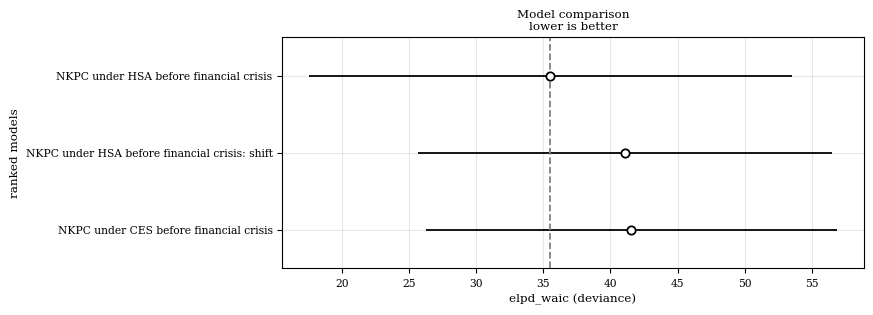

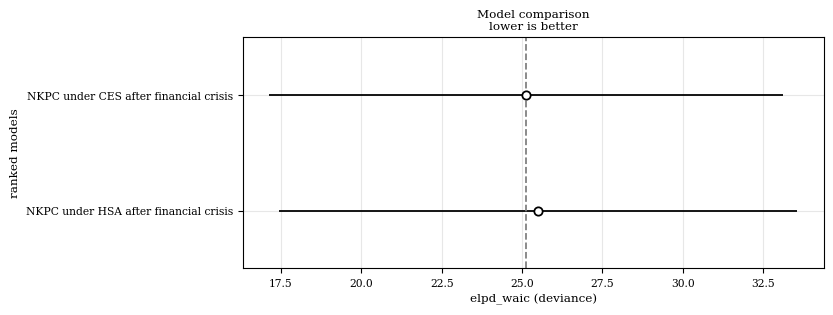

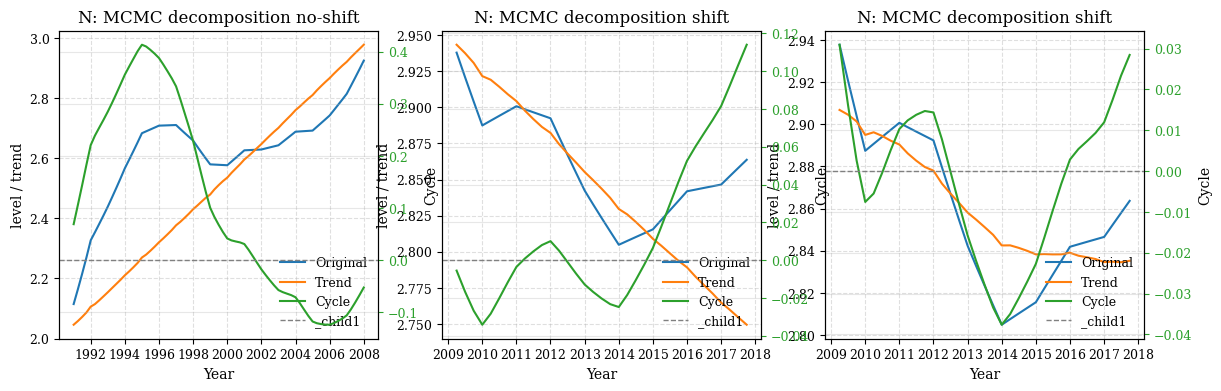

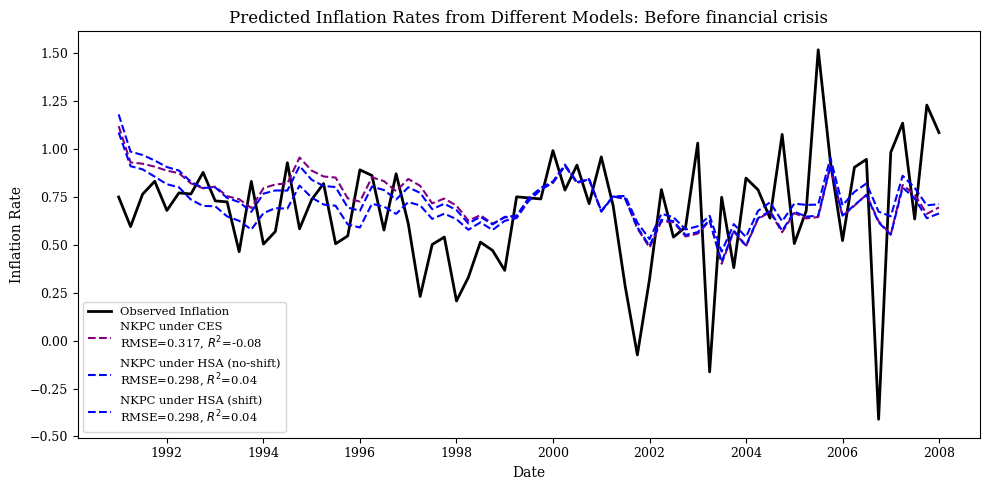

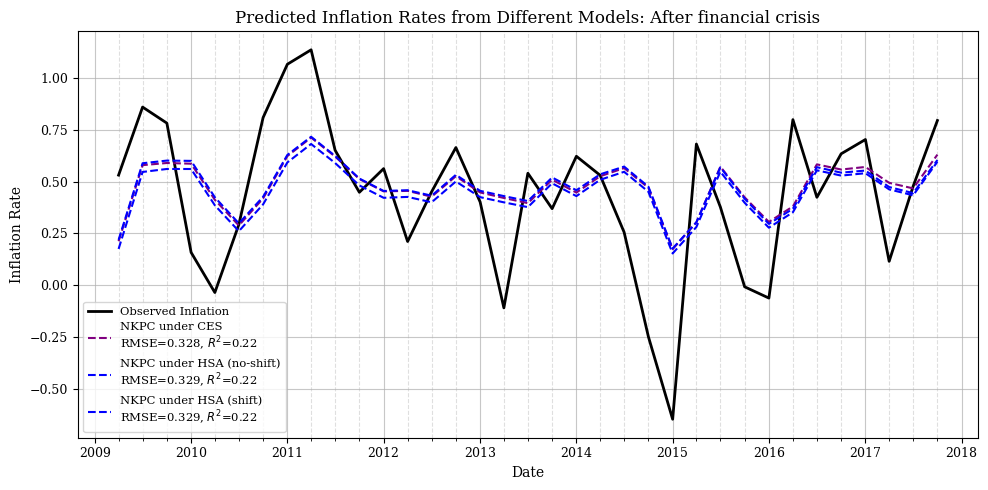

In [75]:
dict_idata = {'NKPC under CES before financial crisis':idata_0_m_1,
              'NKPC under HSA before financial crisis': idata_1_m_1,
              'NKPC under HSA before financial crisis: shift': idata_2_m_1}
df_waic = az.compare(dict_idata, var_name="pi_obs" ,ic='waic', scale='deviance')
df_loo = az.compare(dict_idata, var_name="pi_obs" ,ic='loo', scale='deviance')
scale = 3  # Scale factor for the figure size
az.plot_compare(df_waic, figsize=(2.5*scale, 1*scale))
# az.plot_compare(df_loo, figsize=(2.5*scale, 1*scale))
dict_idata = {'NKPC under CES after financial crisis':idata_0_m_2,
              'NKPC under HSA after financial crisis': idata_1_m_2}
df_waic = az.compare(dict_idata, var_name="pi_obs" ,ic='waic', scale='deviance')
df_loo = az.compare(dict_idata, var_name="pi_obs" ,ic='loo', scale='deviance')
scale = 3  # Scale factor for the figure size
az.plot_compare(df_waic, figsize=(2.5*scale, 1*scale))
# --------------------------------------------------------
# Combined Figure for Model Plots
# --------------------------------------------------------
scale = 2
fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharex=False)
# First decomposition: no shift
plot_decomposition_ax(
    axes[0],
    data_1["DATE"], data_1["N"], N_bar_mean_1_m_1, N_hat_mean_1_m_1,
    "N: MCMC decomposition no-shift", loc="lower right"
)

# Second decomposition: shift
plot_decomposition_ax(
    axes[1],
    data_2["DATE"], data_2["N"], N_bar_mean_1_m_2, N_hat_mean_1_m_2,
    "N: MCMC decomposition shift", loc="lower right"
)
plot_decomposition_ax(
    axes[2],
    data_2["DATE"], data_2["N"], N_bar_mean_2_m_2, N_hat_mean_2_m_2,
    "N: MCMC decomposition shift", loc="lower right"
)

pi_prd_0_1  = idata_0_m_1.posterior["alpha"].mean().item() * pi_prev_1 + (1 - idata_0_m_1.posterior["alpha"].mean().item()) * pi_expect_1 + idata_0_m_1.posterior["kappa"].mean().item() * x_markup_1
pi_pred_1_1 = idata_1_m_1.posterior["alpha"].mean().item() * pi_prev_1 + (1 - idata_1_m_1.posterior["alpha"].mean().item()) * pi_expect_1 + idata_1_m_1.posterior["kappa"].mean().item() * x_markup_1 - idata_1_m_1.posterior["theta"].mean().item() * N_hat_mean_1_m_1
pi_pred_2_1 = idata_2_m_1.posterior["alpha"].mean().item() * pi_prev_1 + (1 - idata_2_m_1.posterior["alpha"].mean().item()) * pi_expect_1 + idata_2_m_1.posterior["kappa"].mean().item() * x_markup_1 - idata_2_m_1.posterior["theta"].mean().item() * N_hat_mean_2_m_1
# --- after you compute pi_pred_1…pi_pred_4 ---
def rmse(pred, obs):
    return np.sqrt(np.mean((pred - obs)**2))

def r2(pred, obs):
    ss_res = np.sum((obs - pred)**2)
    ss_tot = np.sum((obs - np.mean(obs))**2)
    return 1 - ss_res/ss_tot

# compute metrics
rmse0, r20 = rmse(pi_prd_0_1, pi_1), r2(pi_prd_0_1, pi_1)
rmse1, r21 = rmse(pi_pred_1_1, pi_1), r2(pi_pred_1_1, pi_1)
rmse2, r22 = rmse(pi_pred_2_1, pi_1), r2(pi_pred_2_1, pi_1)

# Plotting the predicted inflation rates
plt.figure(figsize=(10, 5))
plt.plot(data_1["DATE"], pi_1, label="Observed Inflation", color='black', linewidth=2)
plt.plot(
    data_1["DATE"], pi_prd_0_1,
    label=f"NKPC under CES \nRMSE={rmse0:.3f}, $R^2$={r20:.2f}",
    color='purple', linestyle='--'
)

plt.plot(
    data_1["DATE"], pi_pred_1_1,
    label=f"NKPC under HSA (no-shift)\nRMSE={rmse1:.3f}, $R^2$={r21:.2f}",
    color='blue', linestyle='--'
)

plt.plot(
    data_1["DATE"], pi_pred_2_1,
    label=f"NKPC under HSA (shift)\nRMSE={rmse1:.3f}, $R^2$={r21:.2f}",
    color='blue', linestyle='--'
)
plt.title("Predicted Inflation Rates from Different Models: Before financial crisis")
plt.xlabel("Date")
plt.ylabel("Inflation Rate")
plt.legend(loc="lower left", fontsize='small', framealpha=0.8)
plt.grid()
plt.tight_layout()
plt.show()


pi_prd_0_2  = idata_0_m_2.posterior["alpha"].mean().item() * pi_prev_2 + (1 - idata_0_m_2.posterior["alpha"].mean().item()) * pi_expect_2 + idata_0_m_2.posterior["kappa"].mean().item() * x_markup_2
pi_pred_1_2 = idata_1_m_2.posterior["alpha"].mean().item() * pi_prev_2 + (1 - idata_1_m_2.posterior["alpha"].mean().item()) * pi_expect_2 + idata_1_m_2.posterior["kappa"].mean().item() * x_markup_2 - idata_1_m_2.posterior["theta"].mean().item() * N_hat_mean_1_m_2
pi_pred_2_2 = idata_2_m_2.posterior["alpha"].mean().item() * pi_prev_2 + (1 - idata_2_m_2.posterior["alpha"].mean().item()) * pi_expect_2 + kappa_mean_2_m_2 * x_markup_2 - idata_2_m_2.posterior["theta"].mean().item() * N_hat_mean_2_m_2
                                                                          
rmse0, r20 = rmse(pi_prd_0_2, pi_2), r2(pi_prd_0_2, pi_2)
rmse1, r21 = rmse(pi_pred_1_2, pi_2), r2(pi_pred_1_2, pi_2)
rmse2, r22 = rmse(pi_pred_2_2, pi_2), r2(pi_pred_2_2, pi_2)

# Plotting the predicted inflation rates
plt.figure(figsize=(10, 5))
plt.plot(data_2["DATE"], pi_2, label="Observed Inflation", color='black', linewidth=2)
plt.plot(
    data_2["DATE"], pi_prd_0_2,
    label=f"NKPC under CES \nRMSE={rmse0:.3f}, $R^2$={r20:.2f}",
    color='purple', linestyle='--'
)

plt.plot(
    data_2["DATE"], pi_pred_1_2,
    label=f"NKPC under HSA (no-shift)\nRMSE={rmse1:.3f}, $R^2$={r21:.2f}",
    color='blue', linestyle='--'
)
plt.plot(
    data_2["DATE"], pi_pred_2_2,
    label=f"NKPC under HSA (shift)\nRMSE={rmse1:.3f}, $R^2$={r21:.2f}",
    color='blue', linestyle='--'
)

plt.title("Predicted Inflation Rates from Different Models: After financial crisis")
plt.xlabel("Date")
plt.ylabel("Inflation Rate")
plt.legend(loc="lower left", fontsize='small', framealpha=0.8)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())         
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[4,7,10,1]))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

plt.legend(loc="lower left", fontsize='small', framealpha=0.8)
plt.grid(which="major", linestyle="-", alpha=0.7)
plt.grid(which="minor", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

In [ ]:
# output gap version.
# NKPC under CES before financial crisis ======================================
print("NKPC under CES before financial crisis")
kernel = NUTS(model_0, target_accept_prob=0.995)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc.run(rng_keys, pi=pi_1, pi_prev=pi_prev_1, pi_expect=pi_expect_1, x=x_outputgap_1)
idata_0_m_1 = az.from_numpyro(mcmc)
posterior_samples = mcmc.get_samples()
diverging  = idata_0_m_1.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()                               # mean of 0/1 booleans = share of divergences
print(f"model 0.1: divergence ratio = {ratio_div:.4%}")     # bool for each param
# =============================================================================

# NKPC under CES after financial crisis =======================================
print("NKPC under CES before financial crisis")
kernel = NUTS(model_0, target_accept_prob=0.995)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc.run(rng_keys, pi=pi_2, pi_prev=pi_prev_2, pi_expect=pi_expect_2, x=x_outputgap_2)
idata_0_m_2 = az.from_numpyro(mcmc)
posterior_samples = mcmc.get_samples()
diverging  = idata_0_m_2.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()                               # mean of 0/1 booleans = share of divergences
print(f"model 0.2: divergence ratio = {ratio_div:.4%}")     # bool for each param
# =============================================================================

# NKPC under HSA: no shift in slope before financial crisis ===================
print("NKPC under HSA: no shift in slope")
# model 1
kernel = NUTS(model_1, target_accept_prob=0.95)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel",progress_bar=True)
mcmc.run(rng_keys, pi=pi_1, pi_prev=pi_prev_1, pi_expect=pi_expect_1, x=x_outputgap_1, N = N_1, l=len(pi_1))
idata_1_m_1 = az.from_numpyro(mcmc)
posterior_samples = mcmc.get_samples()
N_bar_samples_1 = posterior_samples["Nbar"]
N_bar_mean_1_m_1 = np.mean(N_bar_samples_1, axis=0) 
N_bar_std_1_m_1 = np.std(N_bar_samples_1, axis=0)  
N_bar_lower_1_m_1 = N_bar_mean_1_m_1 - 1.97 * N_bar_std_1_m_1
N_bar_upper_1_m_1 = N_bar_mean_1_m_1 + 1.97 * N_bar_std_1_m_1
N_hat_samples_1 = posterior_samples["Nhat"]
N_hat_mean_1_m_1 = np.mean(N_hat_samples_1, axis=0) 
N_hat_std_1_m_1 = np.std(N_hat_samples_1, axis=0)  
N_hat_lower_1_m_1 = N_hat_mean_1_m_1 - 1.97 * N_hat_std_1_m_1
N_hat_upper_1_m_1 = N_hat_mean_1_m_1 + 1.97 * N_hat_std_1_m_1
diverging  = idata_1_m_1.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"Model 1.1 : divergence ratio = {ratio_div:.4%}")
# =============================================================================

# NKPC under HSA: no shift in slope after financial crisis ==================
kernel = NUTS(model_1, target_accept_prob=0.95)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains, chain_method="parallel", progress_bar=True)
mcmc.run(rng_keys, pi=pi_2, pi_prev=pi_prev_2, pi_expect=pi_expect_2, x=x_outputgap_2, N = N_2, l=len(pi_2))
idata_1_m_2 = az.from_numpyro(mcmc)
posterior_samples = mcmc.get_samples()
N_bar_samples_2 = posterior_samples["Nbar"]
N_bar_mean_1_m_2 = np.mean(N_bar_samples_2, axis=0)
N_bar_std_1_m_2 = np.std(N_bar_samples_2, axis=0)
N_bar_lower_1_m_2 = N_bar_mean_1_m_2 - 1.97 * N_bar_std_1_m_2
N_bar_upper_1_m_2 = N_bar_mean_1_m_2 + 1.97 * N_bar_std_1_m_2
N_hat_samples_2 = posterior_samples["Nhat"]
N_hat_mean_1_m_2 = np.mean(N_hat_samples_2, axis=0)
N_hat_std_1_m_2 = np.std(N_hat_samples_2, axis=0)
N_hat_lower_1_m_2 = N_hat_mean_1_m_2 - 1.97 * N_hat_std_1_m_2
N_hat_upper_1_m_2 = N_hat_mean_1_m_2 + 1.97 * N_hat_std_1_m_2
diverging  = idata_1_m_2.sample_stats["diverging"].values   # same shape
ratio_div  = diverging.mean()         # mean of 0/1 booleans = share of divergences
print(f"Model 1.2 : divergence ratio = {ratio_div:.4%}")
# =============================================================================
# Summary statistics
dict_idata = {'NKPC under CES before financial crisis':idata_0_m_1, 'NKPC under CES after financial crisis':idata_0_m_2,
              'NKPC under HSA before financial crisis': idata_1_m_1, 'NKPC under HSA after financial crisis': idata_1_m_2}
params = ["alpha", "kappa", "sigma_v", "theta", "rho_1", "rho_2", "n"]
df_list = []
for model_name, idata in dict_idata.items():
    row = {"model": model_name}
    available_params = list(idata.posterior.data_vars)
    for param in params:
        if param in available_params:
            summary = az.summary(idata, var_names=[param], kind="stats")
            if param in summary.index:
                row[param] = f"{summary.loc[param, 'mean']:.3f}"
            else:
                row[param] = "-"
        else:
            row[param] = "-"
    df_list.append(row)

summary_df = pd.DataFrame(df_list)
display(summary_df)


NKPC under CES before financial crisis


sample: 100%|██████████| 10000/10000 [00:03<00:00, 2603.36it/s, 15 steps of size 1.86e-01. acc. prob=0.99]


model 0.1: divergence ratio = 0.0000%
NKPC under CES before financial crisis


sample: 100%|██████████| 10000/10000 [00:02<00:00, 3890.76it/s, 15 steps of size 1.82e-01. acc. prob=0.99]


model 0.2: divergence ratio = 0.0000%
NKPC under HSA: no shift in slope


sample: 100%|██████████| 10000/10000 [11:57<00:00, 13.94it/s, 1023 steps of size 4.90e-03. acc. prob=0.95]


Model 1.1 : divergence ratio = 0.0000%


sample: 100%|██████████| 10000/10000 [03:22<00:00, 49.27it/s, 767 steps of size 5.33e-03. acc. prob=0.95]


Model 1.2 : divergence ratio = 0.0000%


,model,alpha,kappa,sigma_v,theta,rho_1,rho_2,n
0,NKPC under CES before financial crisis,0.155,0.044,0.324,-,-,-,-
1,NKPC under CES after financial crisis,0.182,0.035,0.359,-,-,-,-
2,NKPC under HSA before financial crisis,0.123,0.048,0.308,0.370,1.923,-0.929,0.015
3,NKPC under HSA after financial crisis,0.183,0.035,0.361,0.264,1.747,-0.762,-0.004


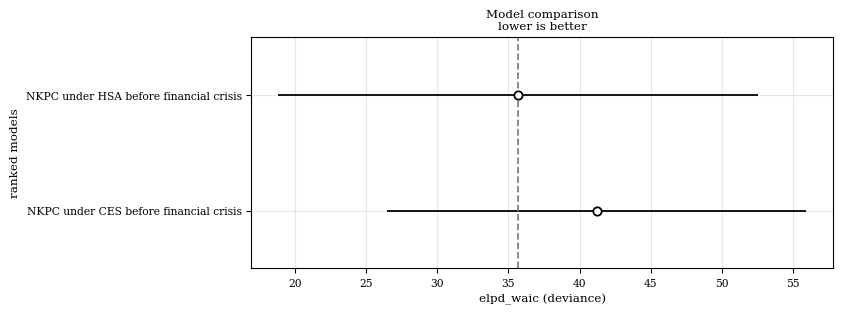

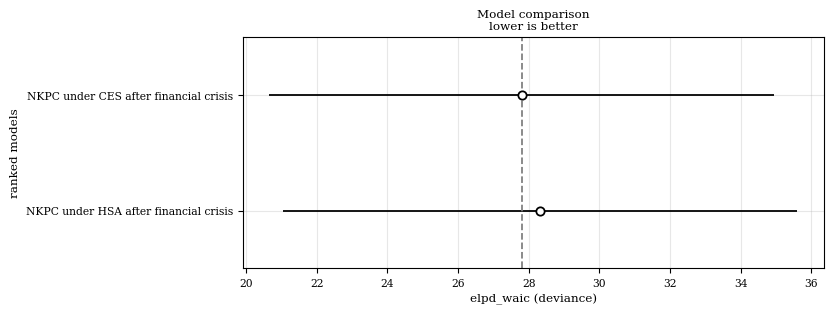

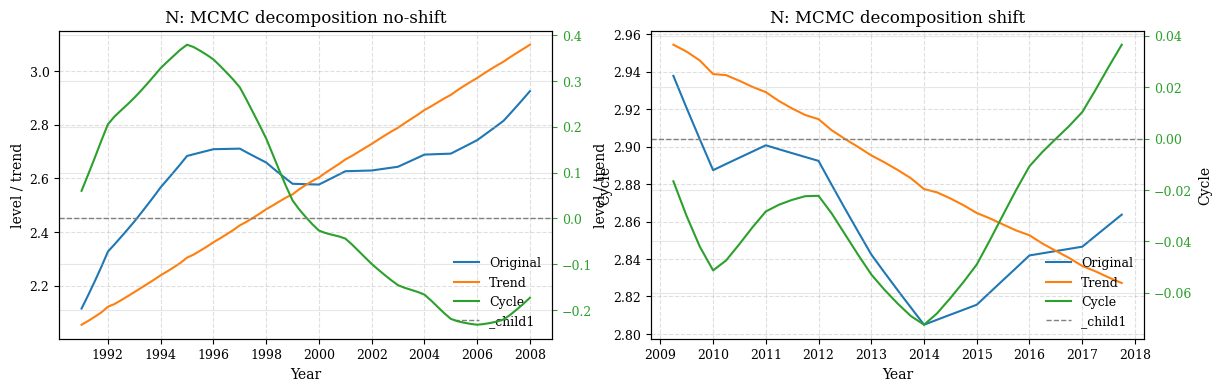

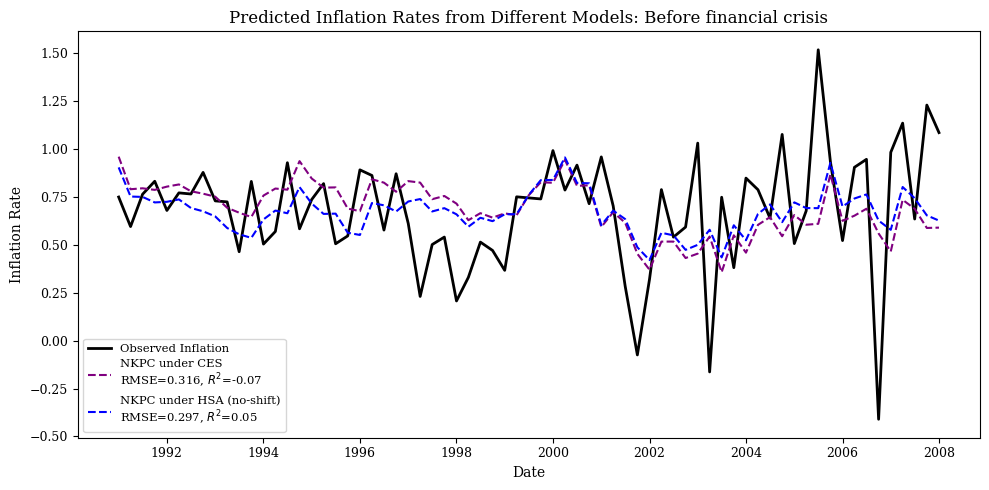

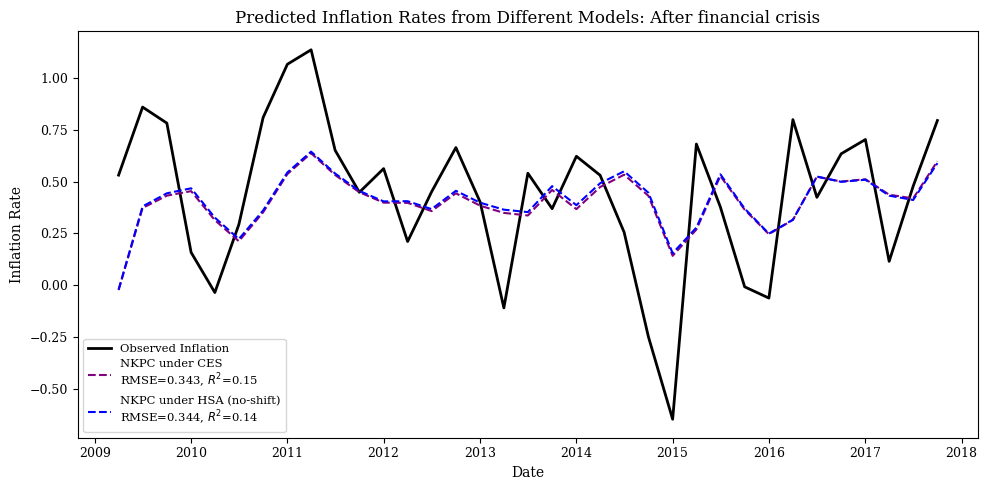

In [ ]:
dict_idata = {'NKPC under CES before financial crisis':idata_0_m_1,
              'NKPC under HSA before financial crisis': idata_1_m_1,}
df_waic = az.compare(dict_idata, var_name="pi_obs" ,ic='waic', scale='deviance')
df_loo = az.compare(dict_idata, var_name="pi_obs" ,ic='loo', scale='deviance')
scale = 3  # Scale factor for the figure size
az.plot_compare(df_waic, figsize=(2.5*scale, 1*scale))
# az.plot_compare(df_loo, figsize=(2.5*scale, 1*scale))
dict_idata = {'NKPC under CES after financial crisis':idata_0_m_2,
              'NKPC under HSA after financial crisis': idata_1_m_2}
df_waic = az.compare(dict_idata, var_name="pi_obs" ,ic='waic', scale='deviance')
df_loo = az.compare(dict_idata, var_name="pi_obs" ,ic='loo', scale='deviance')
scale = 3  # Scale factor for the figure size
az.plot_compare(df_waic, figsize=(2.5*scale, 1*scale))
# --------------------------------------------------------
# Combined Figure for Model Plots
# --------------------------------------------------------
scale = 2
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharex=False)
# First decomposition: no shift
plot_decomposition_ax(
    axes[0],
    data_1["DATE"], data_1["N"], N_bar_mean_1_m_1, N_hat_mean_1_m_1,
    "N: MCMC decomposition no-shift", loc="lower right"
)

# Second decomposition: shift
plot_decomposition_ax(
    axes[1],
    data_2["DATE"], data_2["N"], N_bar_mean_1_m_2, N_hat_mean_1_m_2,
    "N: MCMC decomposition shift", loc="lower right"
)

pi_prd_0_1  = idata_0_m_1.posterior["alpha"].mean().item() * pi_prev_1 + (1 - idata_0_m_1.posterior["alpha"].mean().item()) * pi_expect_1 + idata_0_m_1.posterior["kappa"].mean().item() * x_outputgap_1
pi_pred_1_1 = idata_1_m_1.posterior["alpha"].mean().item() * pi_prev_1 + (1 - idata_1_m_1.posterior["alpha"].mean().item()) * pi_expect_1 + idata_1_m_1.posterior["kappa"].mean().item() * x_outputgap_1 - idata_1_m_1.posterior["theta"].mean().item() * N_hat_mean_1_m_1

# --- after you compute pi_pred_1…pi_pred_4 ---
def rmse(pred, obs):
    return np.sqrt(np.mean((pred - obs)**2))

def r2(pred, obs):
    ss_res = np.sum((obs - pred)**2)
    ss_tot = np.sum((obs - np.mean(obs))**2)
    return 1 - ss_res/ss_tot

# compute metrics
rmse0, r20 = rmse(pi_prd_0_1, pi_1), r2(pi_prd_0_1, pi_1)
rmse1, r21 = rmse(pi_pred_1_1, pi_1), r2(pi_pred_1_1, pi_1)

# Plotting the predicted inflation rates
plt.figure(figsize=(10, 5))
plt.plot(data_1["DATE"], pi_1, label="Observed Inflation", color='black', linewidth=2)
plt.plot(
    data_1["DATE"], pi_prd_0_1,
    label=f"NKPC under CES \nRMSE={rmse0:.3f}, $R^2$={r20:.2f}",
    color='purple', linestyle='--'
)

plt.plot(
    data_1["DATE"], pi_pred_1_1,
    label=f"NKPC under HSA (no-shift)\nRMSE={rmse1:.3f}, $R^2$={r21:.2f}",
    color='blue', linestyle='--'
)
plt.title("Predicted Inflation Rates from Different Models: Before financial crisis")
plt.xlabel("Date")
plt.ylabel("Inflation Rate")
plt.legend(loc="lower left", fontsize='small', framealpha=0.8)
plt.grid()
plt.tight_layout()
plt.show()


pi_prd_0_2  = idata_0_m_2.posterior["alpha"].mean().item() * pi_prev_2 + (1 - idata_0_m_2.posterior["alpha"].mean().item()) * pi_expect_2 + idata_0_m_2.posterior["kappa"].mean().item() * x_outputgap_2
pi_pred_1_2 = idata_1_m_2.posterior["alpha"].mean().item() * pi_prev_2 + (1 - idata_1_m_2.posterior["alpha"].mean().item()) * pi_expect_2 + idata_1_m_2.posterior["kappa"].mean().item() * x_outputgap_2 - idata_1_m_2.posterior["theta"].mean().item() * N_hat_mean_1_m_2

# compute metrics
rmse0, r20 = rmse(pi_prd_0_2, pi_2), r2(pi_prd_0_2, pi_2)
rmse1, r21 = rmse(pi_pred_1_2, pi_2), r2(pi_pred_1_2, pi_2)

# Plotting the predicted inflation rates
plt.figure(figsize=(10, 5))
plt.plot(data_2["DATE"], pi_2, label="Observed Inflation", color='black', linewidth=2)
plt.plot(
    data_2["DATE"], pi_prd_0_2,
    label=f"NKPC under CES \nRMSE={rmse0:.3f}, $R^2$={r20:.2f}",
    color='purple', linestyle='--'
)

plt.plot(
    data_2["DATE"], pi_pred_1_2,
    label=f"NKPC under HSA (no-shift)\nRMSE={rmse1:.3f}, $R^2$={r21:.2f}",
    color='blue', linestyle='--'
)
plt.title("Predicted Inflation Rates from Different Models: After financial crisis")
plt.xlabel("Date")
plt.ylabel("Inflation Rate")
plt.legend(loc="lower left", fontsize='small', framealpha=0.8)
plt.grid()
plt.tight_layout()
plt.show()